In [1]:
import cobra
from cobra import Reaction, Metabolite, Model
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
from scipy.stats import fisher_exact
from operator import itemgetter
import seaborn as sns
import copy

# Load Model

In [2]:
#minimal media : 'o2_mgso4_nh4_so4_nacl_nh4cl_kh2po4_na2hpo4'

In [3]:
#iJN1463 - putida model

model_putida = cobra.io.load_json_model('data/SI3_iJN1411final_flux_w_rhamnolipid_biosynthesis.json')
model_putida.objective = model_putida.reactions.BiomassKT2440_WT3.flux_expression
model_putida.reactions.EX_glyc_e_.lower_bound = 0
model_putida.reactions.ATPM.bounds = -1,1
model_putida.name = 'iJN1463 - putida model'

In [4]:
#e-coli model

model_e_coli = cobra.io.load_json_model('data/iEC1344_C.json')
model_e_coli.name = 'E-coli model'

In [5]:
#Pseudomonas aeruginosa model iPau21

model_iPau21 = cobra.io.read_sbml_model('data/iPau21/iPau21.xml')
model_iPau21.reactions.ATPM.bounds = -10,10

for rea in model_iPau21.reactions :
    rea.name = rea.name.replace('-','_')

EX_reactions = []
for rea in model_iPau21.reactions :
    if rea.id[:2] == 'EX':
        EX_reactions.append(rea.id)

non_carbon_source = []

for i in range(len(EX_reactions)) :
    cs = False
    f = model_iPau21.reactions.get_by_id(EX_reactions[i]).reactants[0].formula
    if 'C' in f:
        if not('Ca' in f) :
            if not('Cd' == f or 'Cl' == f or 'CO2' == f or 'Co'==f or 'Cu' == f or 'CNO'==f):
                cs = True
    if not(cs) :
        non_carbon_source.append(EX_reactions[i])
        if model_iPau21.reactions.get_by_id(EX_reactions[i]).lower_bound == 0 :
            model_iPau21.reactions.get_by_id(EX_reactions[i]).lower_bound=-1000
model_iPau21.name = 'UCBPP-PA14'

In [6]:
#Pseudomonas aeruginosa model ISD1509

model_ISD1509 = cobra.io.read_sbml_model('data/ISD1509/model.xml')
model_ISD1509.reactions.ATPM.bounds = -10,10
for meta in model_ISD1509.reactions :
    if 'ex_' in meta.id.lower() :
        if 'c' in model_ISD1509.reactions.get_by_id(meta.id).reactants[0].formula.lower():
            if not(meta.lower_bound == -999999.0):
                meta.lower_bound = 0

https://doi.org/10.1101/2021.03.10.434463 does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id


In [7]:
#Choose your model

model = model_iPau21

# Biomass optimization for different carbon nutrients

In [8]:
#Find the exchange reactions of the BIOLOG's nutrients in the model

metabolites_txt = re.split('\t|\n',open('data/Metabolites_PM1_PM2A.txt').read())[6:]
PM1_metabolites, PM2a_metabolites = metabolites_txt[1::3], metabolites_txt[2::3]

EX_reactions = []
for rea in model.reactions :
    if rea.id[:2] == 'EX':
        EX_reactions.append(rea.id)

        
def corresponding_reaction(metabolite):
    duplicates = []
    meta = metabolite.replace('a_','').replace('g_','').replace('b_','').replace('Acid','').replace('Two_','').replace('Three_','')
    for nutrient in EX_reactions :    
        if meta.lower() in model.reactions.get_by_id(nutrient).name.lower() :
            duplicates.append(nutrient)
    if metabolite == 'Three_Hydroxy2_Butanone' :
        if model.name == 'iJN1463 - putida model' :
            duplicates.append('EX_actn_R_e_')  
    
    if len(duplicates) >= 1 :
        return min(duplicates, key = len)
    else :
        return None

carbon_nutrients_EX = []
for metabolite in PM1_metabolites + PM2a_metabolites :
    nutrient = corresponding_reaction(metabolite)
    if not(nutrient is None):
        model.reactions.get_by_id(nutrient).lower_bound = 0
        carbon_nutrients_EX.append(nutrient)
        
print('There are {} carbonated nutrients in the model out of the 190 of the BIOLOG'.format(len(carbon_nutrients_EX)))

There are 43 carbonated nutrients in the model out of the 190 of the BIOLOG


In [28]:
for n in EX_reactions : 
    if 'gly' in model.reactions.get_by_id(n).name.lower() :
        print(model.reactions.get_by_id(n).name)

EX Cys_Gly e
EX gly_asn_L e
EX gly_asp_L e
EX Glycerol e
EX Glycerol_3_phosphate e
EX Glycine e
EX Glycolate
EX Gly_Cys e
EX Gly_Gln e
EX gly_glu_L e
EX Gly_Leu e
EX Gly_Met e
EX Gly_Phe e
EX gly_pro_L e
EX Gly_Tyr e
EX L_alanylglycine e
EX Glycolaldehyde


In [9]:
#Compute the model's predictions for each nutrient in the BIOLOG : 0 is no growth and 1 is growth

lb = -10

solutions = {nutrient:0 for nutrient in carbon_nutrients_EX}
for nutrient in carbon_nutrients_EX :
    model.reactions.get_by_id(nutrient).lower_bound = lb
    solutions[nutrient] = int(model.slim_optimize()> 1e-3)
    model.reactions.get_by_id(nutrient).lower_bound = 0

# Comparing with measurment on PA14

In [10]:
#Usefull functions

def fisher_test(measurment, model_predictions):
    confusion_matrix = np.zeros((2,2))
    for metabolite in measurment.keys():
        nutrient = corresponding_reaction(metabolite)
        if not(nutrient is None):
            confusion_matrix[solutions[nutrient], measurment[metabolite]] += 1
        else :
            confusion_matrix[0, measurment[metabolite]] += 1
    return confusion_matrix, fisher_exact(confusion_matrix).pvalue

def get_formula_EX(nutrient_id):
    if model.name == 'UCBPP-PA14' :
        return model.reactions.get_by_id(nutrient_id).reactants[0].formula
    return model.metabolites.get_by_id(model.reactions.get_by_id(nutrient_id).reaction[:-5]).name.split('_')[-1]

measurment_xlsx = pd.read_excel('data/raw_data_biolog_Pseudomonas.xlsx')

Strain #1 : pvalue = 8.28e-07
Accuracy : 68.42%
Strain #2 : pvalue = 5.97e-03
Accuracy : 70.53%
Strain #3 : pvalue = 2.02e-08
Accuracy : 67.89%
Strain #4 : pvalue = 1.19e-06
Accuracy : 62.11%
Mean pvalue : 1.49e-03


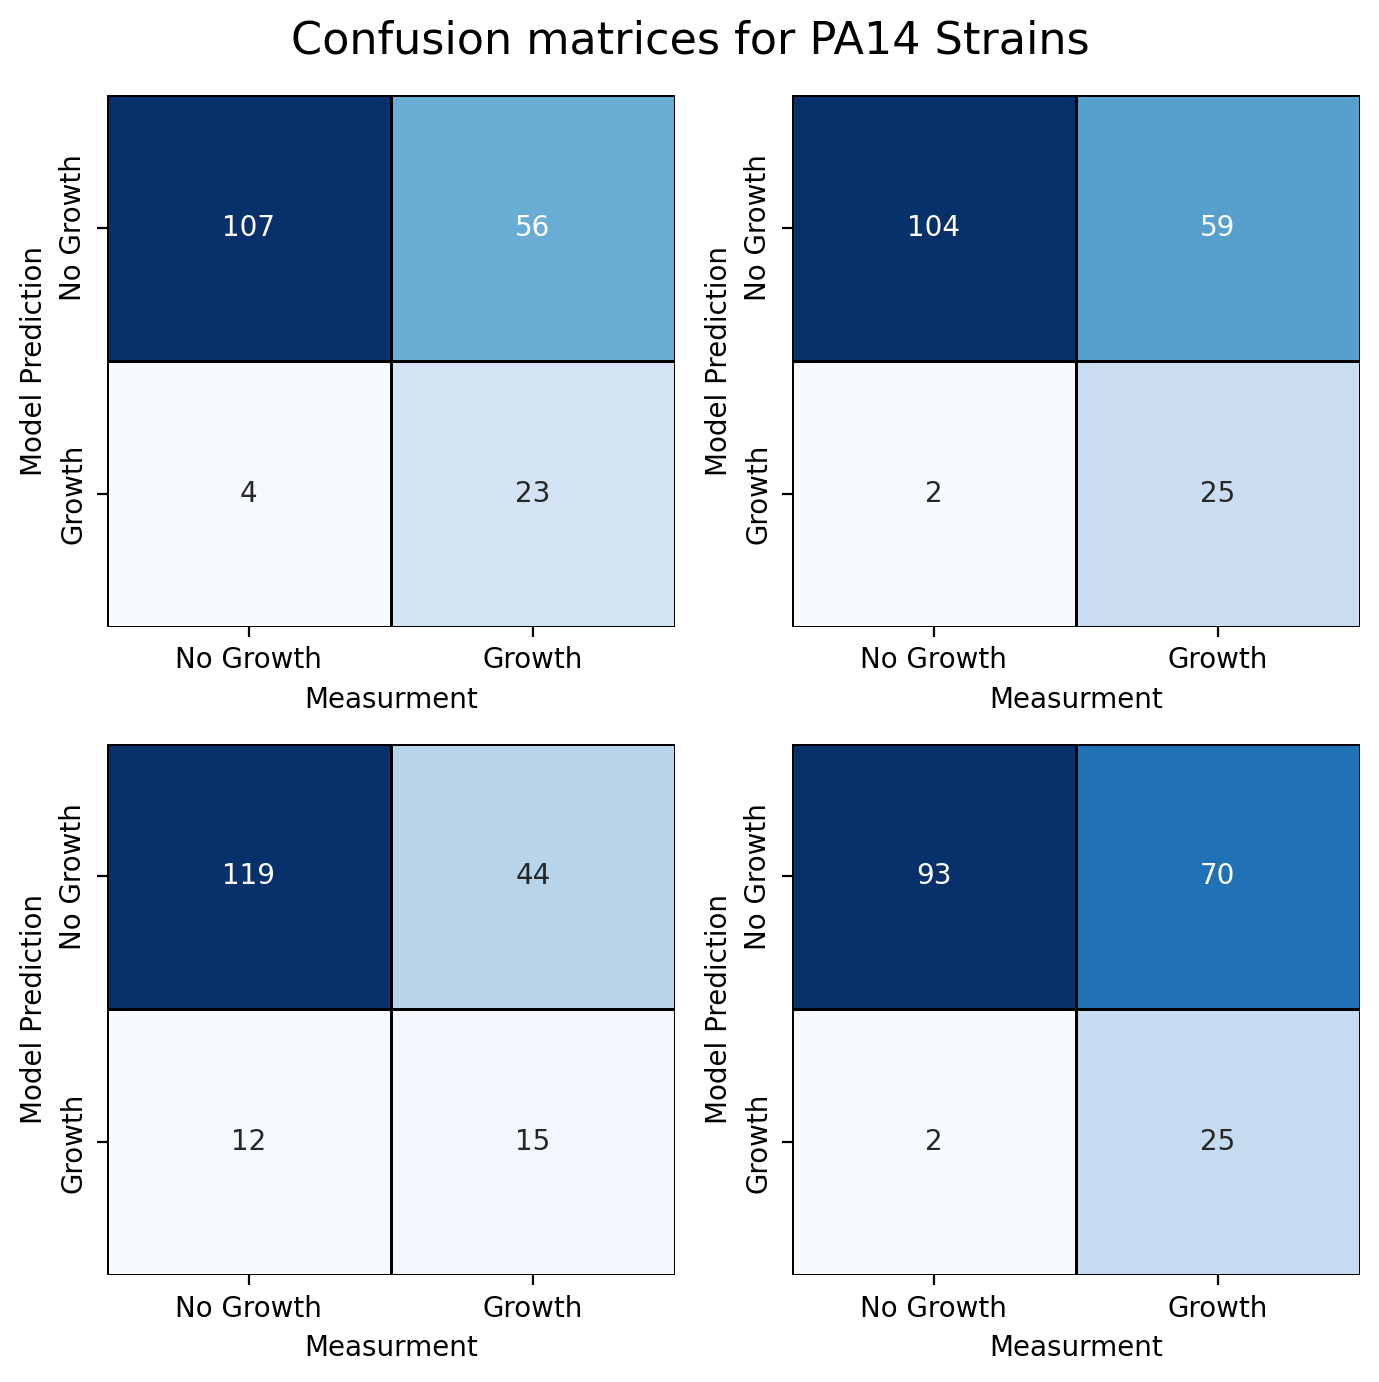

In [11]:
#Compare the measurment with the data : compute the p-values and plot the confusion matrices

names = ['PA14', 'PA14.2', 'PA14.3', 'PA14.4']
cm_array = np.zeros((4,2,2))
pvalues_array = np.zeros(4)
ratio = 0.5

for j in range(4):
    control_value_PM1  = measurment_xlsx[names[j]][2]
    measurment_PM1 = {measurment_xlsx['Strain:'][i]: int(measurment_xlsx[names[j]][i]- control_value_PM1 > ratio*control_value_PM1) for i in range(3,98)}
    control_value_PM2a  = measurment_xlsx[names[j]][104]
    measurment_PM2a = {measurment_xlsx['Strain:'][i]: int(measurment_xlsx[names[j]][i]- control_value_PM2a > ratio*control_value_PM2a) for i in range(105,200)}
    cm, pvalue = fisher_test(measurment_PM1 | measurment_PM2a, solutions)
    cm_array[j] = cm
    pvalues_array[j] = pvalue

    print('Strain #{} : pvalue = {:2.2e}'.format(j+1, pvalue))
    print('Accuracy : {:2.2%}'.format((cm[0,0]+cm[1,1])/190))
print('Mean pvalue : {:2.2e}'.format(np.mean(pvalues_array)))

fig, axs= plt.subplots(2,2, figsize=(7,7), dpi = 200)
for i in range(2):
    for j in range(2):
        ax= axs[i,j]
        sns.heatmap(cm_array[i+2*j], annot=True, fmt='g', ax=ax, cbar = False, cmap = 'Blues', linecolor = 'k', linewidth = 0.5)

        ax.set_xlabel('Measurment');ax.set_ylabel('Model Prediction')
        #ax.set_title('Confusion Matrix #{}'.format(i+2*j+1))
        ax.xaxis.set_ticklabels(['No Growth', 'Growth']); ax.yaxis.set_ticklabels(['No Growth', 'Growth'])
fig.suptitle('Confusion matrices for PA14 Strains', fontsize=16)
fig.tight_layout()

In [12]:
#Plot confusion matrices standard deviation

#ax = plt.subplot()
#sns.heatmap(np.std(cm_array, axis = 0), annot=True, fmt='g', ax=ax, cbar = False, cmap = 'Blues', linecolor = 'k', linewidth = 0.7)
#ax.set_xlabel('Measurment');ax.set_ylabel('Model Prediction')
#ax.set_title('Standard deviation of the confusion matrices')
#ax.xaxis.set_ticklabels(['No Growth', 'Growth']); ax.yaxis.set_ticklabels(['No Growth', 'Growth'])

Text(0.5, 1.0, 'UCBPP-PA14')

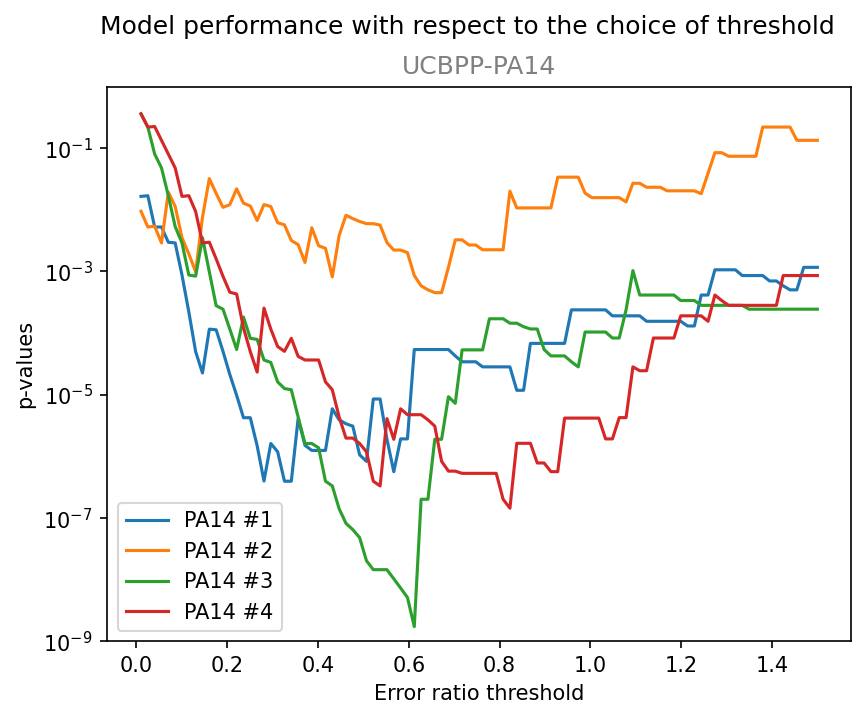

In [13]:
names = ['PA14', 'PA14.2', 'PA14.3', 'PA14.4']

n = 100

ratios = np.linspace(1e-2, 1.5, n)
NG_std = np.zeros(n)
G_std = np.zeros(n)
pvalues_std = np.zeros(n)
pvalues = np.zeros((n,4))


for k, ratio in enumerate(ratios) :
    cm_array = np.zeros((4,2,2))
    pvalues_array = np.zeros(4)
    for j in range(4):
        control_value_PM1  = measurment_xlsx[names[j]][2]
        measurment_PM1 = {measurment_xlsx['Strain:'][i]: int(measurment_xlsx[names[j]][i]- control_value_PM1 > ratio*control_value_PM1) for i in range(3,98)}
        control_value_PM2a  = measurment_xlsx[names[j]][104]
        measurment_PM2a = {measurment_xlsx['Strain:'][i]: int(measurment_xlsx[names[j]][i]- control_value_PM2a > ratio*control_value_PM2a) for i in range(105,200)}

        cm, pvalue = fisher_test(measurment_PM1 | measurment_PM2a, solutions)
        cm_array[j] = cm
        pvalues_array[j] = pvalue
    NG_std[k]= np.std(cm_array, axis = 0)[0,0]
    G_std[k]= np.std(cm_array, axis = 0)[1,1]
    pvalues_std[k]= np.std(pvalues_array)
    pvalues[k] = pvalues_array

plt.figure(dpi = 150)
plt.semilogy(ratios, pvalues, label = ['PA14 #{}'.format(i+1) for i in range(4)])
plt.legend()
plt.xlabel('Error ratio threshold')
plt.ylabel('p-values')
plt.ylim((1e-9,1))
plt.suptitle('Model performance with respect to the choice of threshold')
plt.title(model.name, c = 'gray')

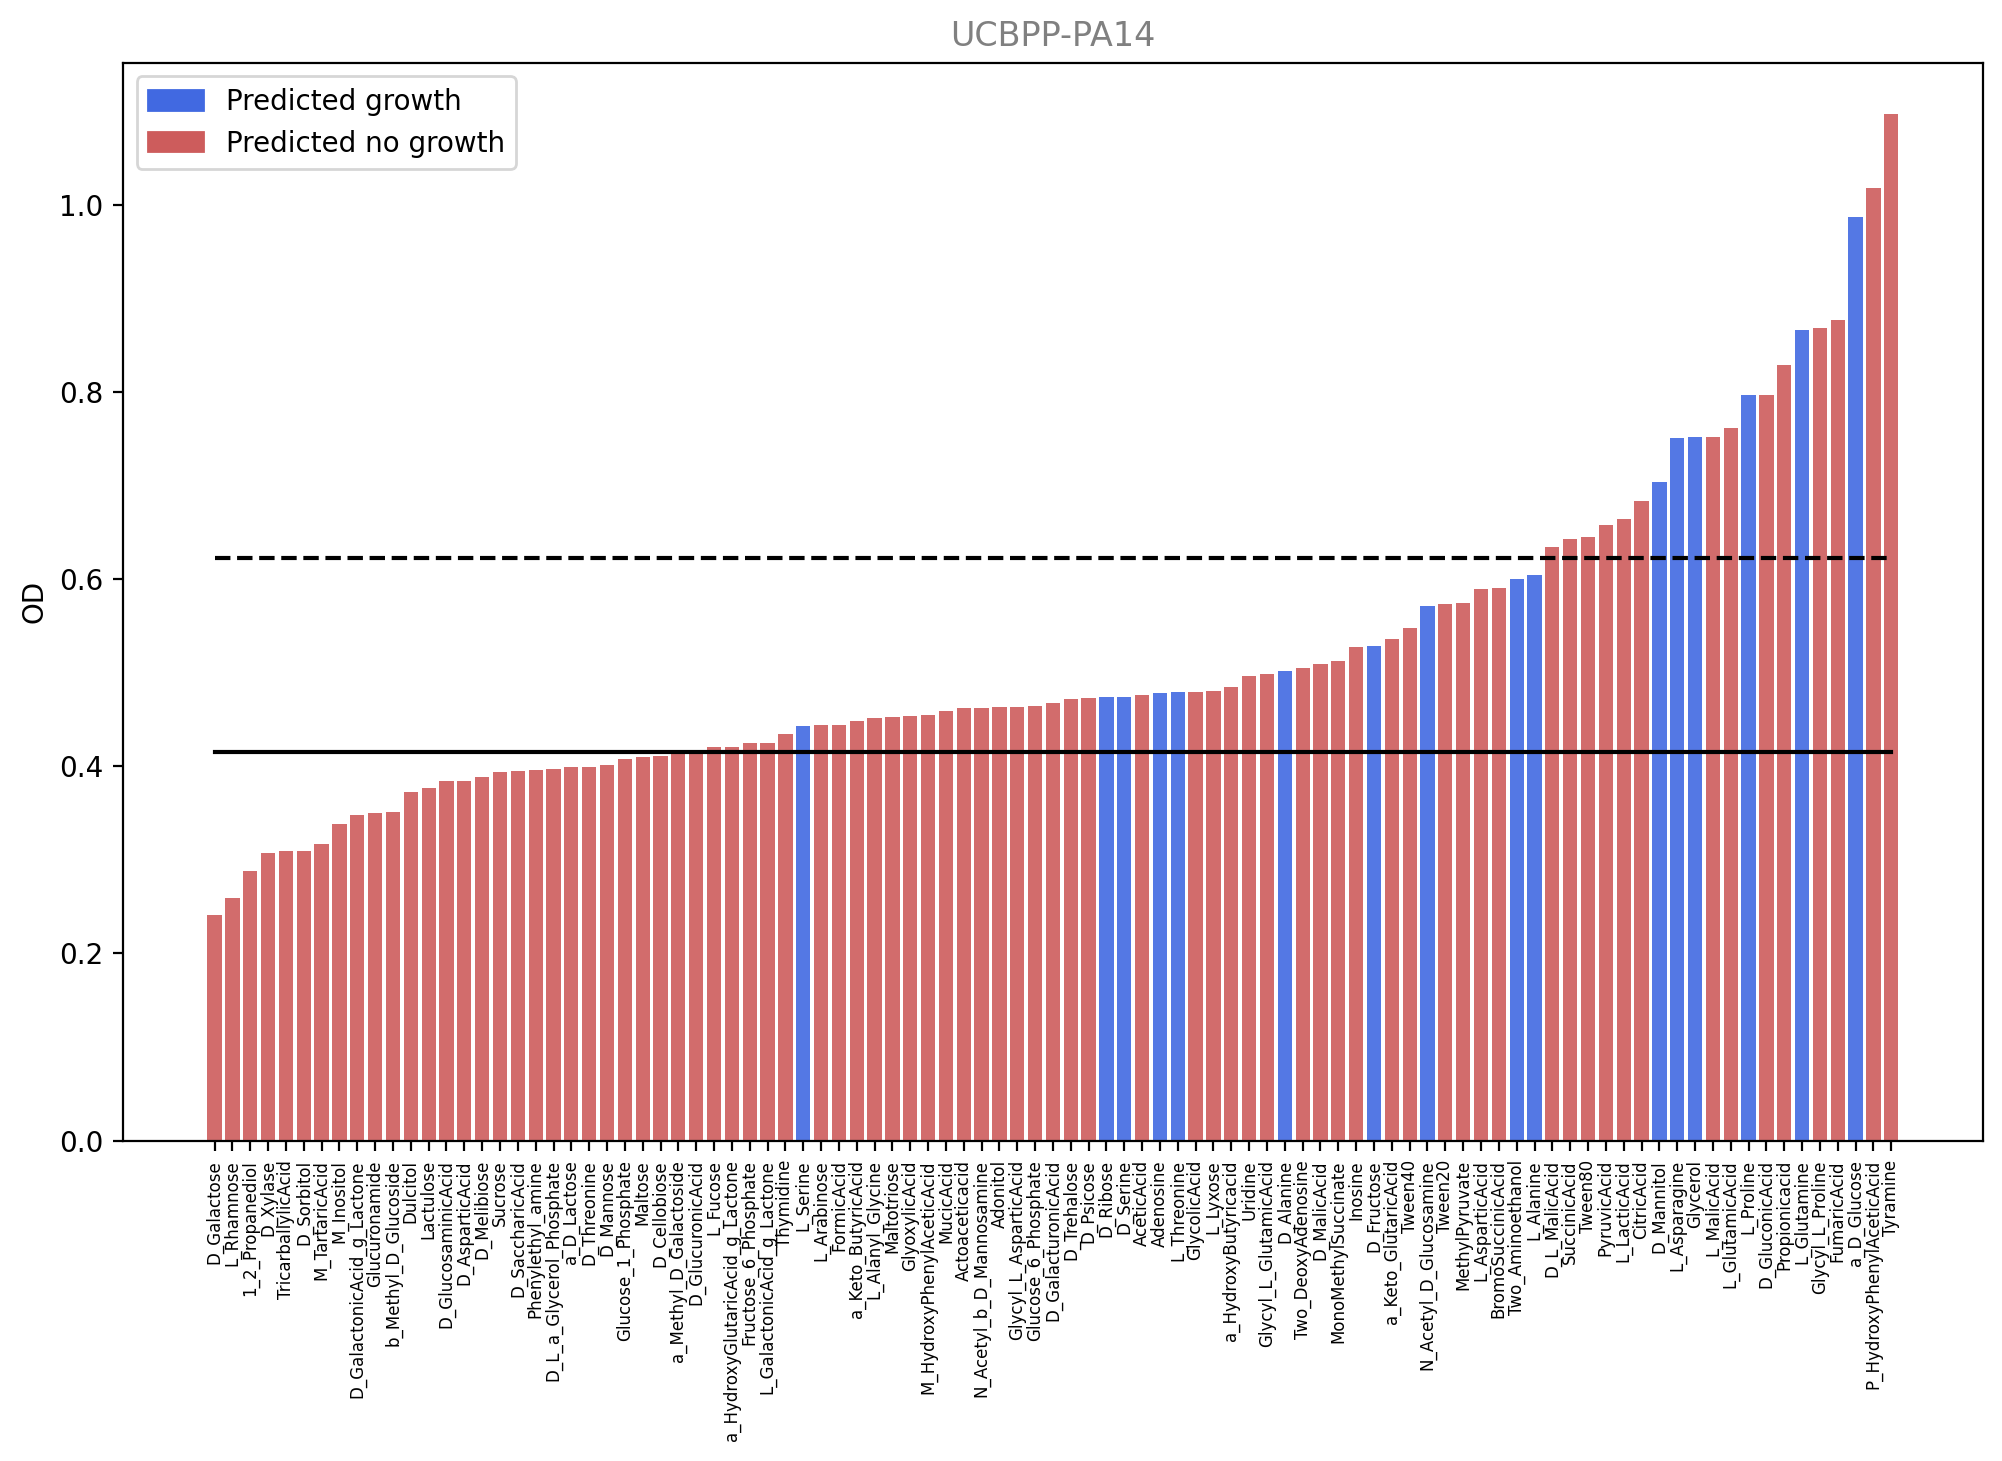

In [14]:
#Plot the OD of the BIOLOG's nutrients of a given strain 

name = 'PA14.2'
ratio = 5e-1

plt.figure(figsize = (12,7), dpi = 200)
colors = []
u = np.sort(np.array(list(measurment_xlsx[name][3:98].items()), dtype = [('order', 'i2'), ('value', 'f4')]), order = 'value')
for e,b in u :
    nutrient = corresponding_reaction(measurment_xlsx['Strain:'][e])
    if nutrient == None :
        colors.append('indianred')
    elif solutions[nutrient] == 0 :
        colors.append('indianred')
    else :
        colors.append('royalblue')

plt.bar(np.arange(95),u['value'], color = colors, alpha = 0.9)
plt.plot(measurment_xlsx[name][2]*np.ones(95), c='k')
plt.plot((1+ratio)*measurment_xlsx[name][2]*np.ones(95), c='k', linestyle = '--')
a = plt.xticks(np.arange(95), [measurment_xlsx['Strain:'][i] for i in u['order']], fontsize = 6, rotation = 90,ha="center")
plt.ylabel('OD')
plt.title(model.name, c = 'gray')
plt.legend([plt.Rectangle((0,0),1,1, color='royalblue'), plt.Rectangle((0,0),1,1, color='indianred')], ['Predicted growth', 'Predicted no growth'])

# Measurment on other strains

Text(0.5, 1.0, 'UCBPP-PA14')

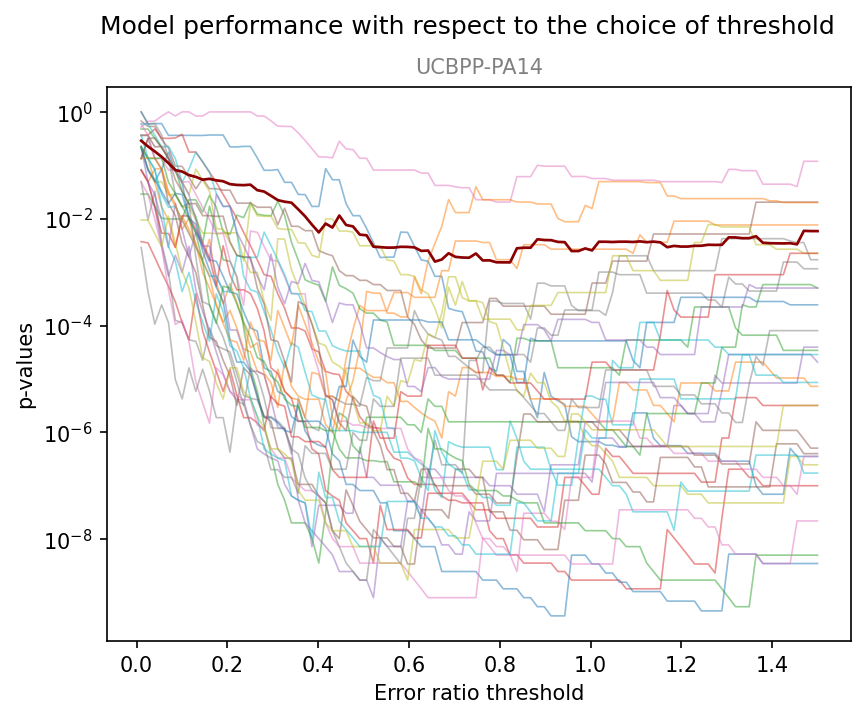

In [15]:
names = list(measurment_xlsx.keys()[9:])

n = 100

ratios = np.linspace(1e-2, 1.5, n)
NG_std = np.zeros(n)
G_std = np.zeros(n)
pvalues_std = np.zeros(n)
pvalues = np.zeros((n,len(names)))


for k, ratio in enumerate(ratios) :
    cm_array = np.zeros((len(names),2,2))
    pvalues_array = np.zeros(len(names))
    for j in range(len(names)):
        control_value_PM1  = measurment_xlsx[names[j]][2]
        measurment_PM1 = {measurment_xlsx['Strain:'][i]: int(measurment_xlsx[names[j]][i]- control_value_PM1 > ratio*control_value_PM1) for i in range(3,98)}
        control_value_PM2a  = measurment_xlsx[names[j]][104]
        measurment_PM2a = {measurment_xlsx['Strain:'][i]: int(measurment_xlsx[names[j]][i]- control_value_PM2a > ratio*control_value_PM2a) for i in range(105,200)}

        cm, pvalue = fisher_test(measurment_PM1 | measurment_PM2a, solutions)
        cm_array[j] = cm
        pvalues_array[j] = pvalue
    NG_std[k]= np.std(cm_array, axis = 0)[0,0]
    G_std[k]= np.std(cm_array, axis = 0)[1,1]
    pvalues_std[k]= np.std(pvalues_array)
    pvalues[k] = pvalues_array

plt.figure(dpi = 150)
plt.semilogy(ratios, pvalues, alpha = 0.5, lw = 0.8)
plt.semilogy(ratios, np.mean(pvalues, axis = 1), c = 'darkred', lw = 1.3)

plt.xlabel('Error ratio threshold')
plt.ylabel('p-values')
plt.suptitle('Model performance with respect to the choice of threshold')
plt.title(model.name, fontsize = 10, c = 'gray')

# Anaerobic growth

In [16]:
lb = -10
O2_exchange = None

for rea in EX_reactions :
    if 'o2' == get_formula_EX(rea).lower() :
        O2_exchange = model.reactions.get_by_id(rea)
        break

if O2_exchange is None :
    raise TypeError('O2 reaction not found')

O2_exchange.lower_bound = 0
solutions_anaerobic = {nutrient:0 for nutrient in carbon_nutrients_EX}
for nutrient in carbon_nutrients_EX :
    model.reactions.get_by_id(nutrient).lower_bound = lb
    solutions_anaerobic[nutrient] = int(model.slim_optimize()> 1e-3)
    model.reactions.get_by_id(nutrient).lower_bound = 0

if np.max([solutions_anaerobic[i] for i in solutions.keys()]) == 0 :
    print("The model doesn't predict growth in anaerobic conditions")
else :
    print("The model predicts growth in anaerobic conditions")

The model doesn't predict growth in anaerobic conditions


# Gap filling the model

In [17]:
raise TypeError('Not finished yet')

TypeError: Not finished yet

In [ ]:
new_model = model.copy()
new_carbon_nutrients_EX = copy.deepcopy(carbon_nutrients_EX)

In [18]:
#Finding the commun missing nutrients to all the strains
names = list(measurment_xlsx.keys()[5:9])
ratio = 0.5

control_values_PM1 = {name:measurment_xlsx[name][2] for name in names}
control_values_PM2a = {name:measurment_xlsx[name][104] for name in names}

false_negative_dict = {}

for i, metabolite in enumerate(PM1_metabolites) :
    nutrient = corresponding_reaction(metabolite)
    if nutrient is None :
        false_negative_dict.update({metabolite:0})
        for name in names :
            if measurment_xlsx[name][i+3]- control_values_PM1[name] > ratio*control_values_PM1[name] :
                false_negative_dict[metabolite] += 100/len(names)
        if false_negative_dict[metabolite] == 0 :
            del false_negative_dict[metabolite]

for i, metabolite in enumerate(PM2a_metabolites) :
    nutrient = corresponding_reaction(metabolite)
    if nutrient is None :
        false_negative_dict.update({metabolite:0})
        for name in names :
            if measurment_xlsx[name][i+3]- control_values_PM2a[name] > ratio*control_values_PM2a[name] :
                false_negative_dict[metabolite] += 100/len(names)
        if false_negative_dict[metabolite] == 0 :
            del false_negative_dict[metabolite]

false_negative_array = np.sort(np.array(list(false_negative_dict.items()), dtype=[('x', 'U300'), ('y', 'f4')]), axis = 0, order = 'y')

In [21]:
false_negative_array[::-1]

array([('g_Cyclodextrin', 100.), ('b_Methyl_D_GlucuronicAcid', 100.),
       ('b_Methyl_D_Galactoside', 100.), ('b_D_Allose', 100.),
       ('a_KetoValericAcid', 100.), ('a_Cyclodextrin', 100.),
       ('Tyramine', 100.), ('Two_Deoxy_D_Ribose', 100.),
       ('Tween80', 100.), ('Turanose', 100.),
       ('Three_MethylGlucose', 100.), ('Three_Hydroxy2_Butanone', 100.),
       ('Three_0_b_D_Galacto_pyranosyl_D_Arabinose', 100.),
       ('SuccinicAcid', 100.), ('SuccinamicAcid', 100.),
       ('Stachyose', 100.), ('SorbicAcid', 100.),
       ('Sec_Butylamine', 100.), ('QuinicAcid', 100.),
       ('Propionicacid', 100.), ('P_HydroxyPhenylAceticAcid', 100.),
       ('OxalomalicAcid', 100.), ('N_Acetyl_L_GlutamicAcid', 100.),
       ('Maltitol', 100.), ('MalonicAcid', 100.), ('Lactitol', 100.),
       ('L_TartaricAcid', 100.), ('L_Ornithine', 100.),
       ('L_MalicAcid', 100.), ('L_Alaninamide', 100.), ('Inulin', 100.),
       ('Glycyl_L_Proline', 100.), ('Glycogen', 100.), ('Gelatin', 100.

In [ ]:
#Find the missing exchange reactions for metabolites that are already in the model
missing_EX = []
formula_xlsx = pd.read_excel('data/BIOLOG_chemical_formulas.xlsx')

for name,e in false_negative_array[::-1] :
    if e > 50 :
        for meta in model.metabolites :
            if meta.name.split('_')[-1] == formula_xlsx[name][0] :
                if (name.lower() in meta.name.lower()) or (name.replace('_D_','').replace('Two_','').lower() in meta.name.lower()) :
                    print((name, meta.id))
                    missing_EX.append(meta)

In [ ]:
for metabolite_c in missing_EX :
    metabolite_e = Metabolite(metabolite_c.id[:-2] + '_e',#
                             name = metabolite_c.name,     #
                             compartment = 'e')
    metabolite_p = Metabolite(metabolite_c.id[:-2] + '_p',#
                             name = metabolite_c.name,     #
                             compartment = 'p')
    EX_reaction = Reaction('EX_'+metabolite_e.id)
    EX_reaction.name = 'R_'+ '_'.join(metabolite_c.name.split('_')[1:-1])+'_exchange'
    EX_reaction.add_metabolites({metabolite_e:-1})
    EX_reaction.bounds = 0, 999999.0
    
    tex_reaction = Reactions(metabolite_e[:-2]+'tex')
    tex_reaction.name = 'R_'+ '_'.join(metabolite_c.name.split('_')[1:-1])+'_transport_via_diffusion__extracellular_to_periplasm_'
    tex_reaction.add_metabolites({metabolite_e:-1, metabolite_p:1})
    tex_reaction.bounds = -999999.0, 999999.0
    
    new_model.add_reactions([EX_reaction, tex_reaction])